# Pediatric Pneumonia Detection - Complete Pipeline

This notebook implements the complete end-to-end workflow for detecting pneumonia in pediatric chest X-rays. 

**Workflow:**
1.  **Data Preparation**: Download dataset from Kaggle, explore structure, and create data generators.
2.  **Training**: Train a ResNet-50 model using specific two-stage transfer learning (Feature Extraction + Fine-Tuning).
3.  **Evaluation**: Evaluate performance on the test set using comprehensive metrics (Accuracy, AUC, Sensitivity, Specificity).
4.  **Explainability**: Visualize model focus regions using Grad-CAM.

---

## 1. Environment Setup
Import necessary libraries and project modules.

In [ ]:
import sys
import os
import kagglehub
from pathlib import Path

# Add project root to path to import model_core
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from model_core.data_pipeline import DataPipeline
from model_core.model_builder import ModelBuilder
from model_core.trainer import Trainer
from model_core.evaluator import ModelEvaluator
from model_core.gradcam import GradCAMVisualizer
from model_core.utils import Utils

# Configuration
OUTPUT_DIR = "../outputs"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

2025-12-31 00:28:13.885057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767140894.067308      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767140894.126749      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767140894.594665      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767140894.594734      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767140894.594738      55 computation_placer.cc:177] computation placer alr

## 2. Data Preparation
We download the dataset from Kaggle and prepare the data generators.

In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Set dataset path
DATASET_PATH = os.path.join(path, "chest_xray")
print(f"Using dataset at: {DATASET_PATH}")

Path to dataset files: /kaggle/input/chest-xray-pneumonia
Using dataset at: /kaggle/input/chest-xray-pneumonia/chest_xray


In [3]:
# Initialize pipeline
pipeline = DataPipeline(DATASET_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

# Explore dataset structure
stats = pipeline.explore_dataset()

# Create stratified validation split
pipeline.create_validation_split(val_ratio=0.15)

# Create data generators
train_gen, val_gen, test_gen = pipeline.create_generators(use_augmentation=True)

# Calculate class weights for imbalance handling
class_weights = Utils.calculate_class_weights(train_gen)

Data Pipeline Initialized
📁 Base Path: /kaggle/input/chest-xray-pneumonia/chest_xray
📐 Image Size: (224, 224)
📦 Batch Size: 32

──────────────────────────────────────────────────────────────────────
📊 EXPLORING DATASET
──────────────────────────────────────────────────────────────────────

📈 Dataset Statistics:

TRAIN:
  • PNEUMONIA: 3,875 (74.3%)
  • NORMAL: 1,341 (25.7%)
  → Total: 5,216

TEST:
  • PNEUMONIA: 390 (62.5%)
  • NORMAL: 234 (37.5%)
  → Total: 624

VAL:
  • PNEUMONIA: 8 (50.0%)
  • NORMAL: 8 (50.0%)
  → Total: 16

🎯 Total Images: 5,856

──────────────────────────────────────────────────────────────────────
📂 CREATING VALIDATION SPLIT (15%)
──────────────────────────────────────────────────────────────────────
✓ Split: 4,433 train | 783 validation
✓ Leakage Check: ✅ PASS

📊 Class Distribution:
Training:
  • PNEUMONIA: 3,293 (74.3%)
  • NORMAL: 1,140 (25.7%)
Validation:
  • PNEUMONIA: 582 (74.3%)
  • NORMAL: 201 (25.7%)

─────────────────────────────────────────────────────

### Visualize Samples
Let's look at some representative X-ray images from the dataset.

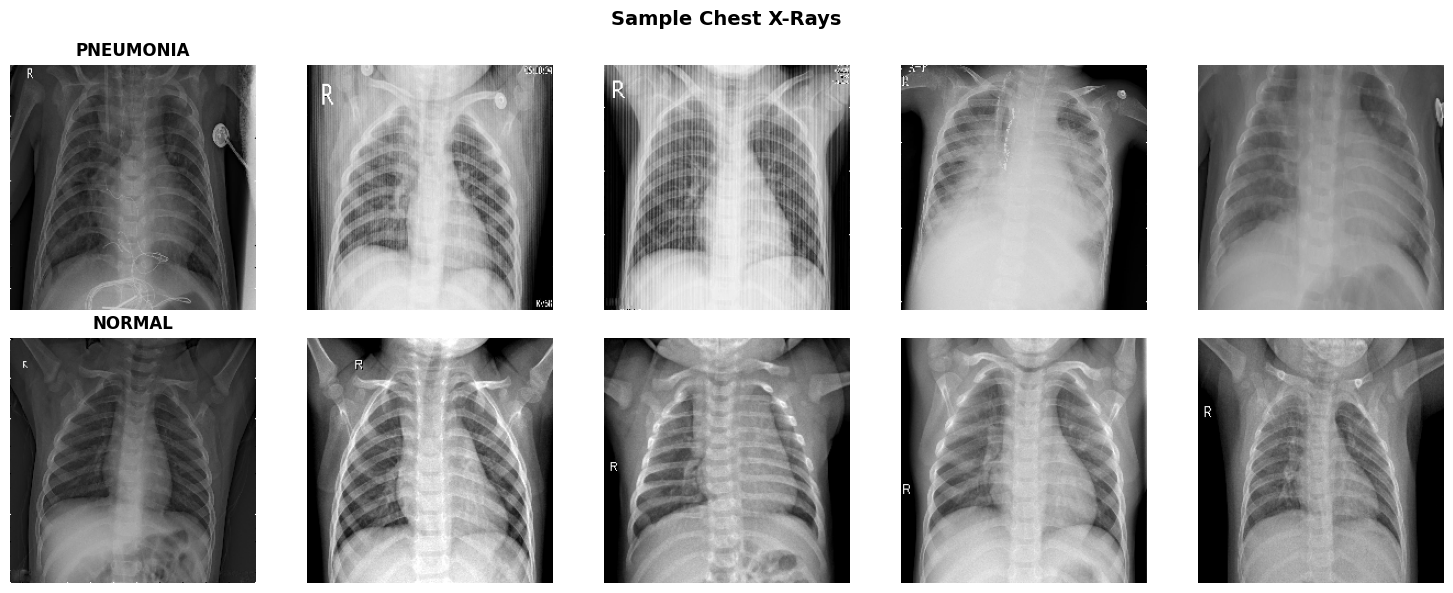

In [4]:
pipeline.visualize_samples()

## 3. Training Stage 1: Feature Extraction
In this stage, we freeze the ResNet-50 backbone and only train the custom classification head.


──────────────────────────────────────────────────────────────────────
🏗️ BUILDING MODEL
──────────────────────────────────────────────────────────────────────


I0000 00:00:1767140916.332294      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ ResNet-50 loaded: 175 layers
🔒 Backbone: FROZEN
✓ Architecture: GAP → FC(512) → Drop → FC(256) → Drop → FC(1)
✓ Total parameters: 24,768,385
✓ Trainable layers: 7/8

──────────────────────────────────────────────────────────────────────
⚙️ COMPILING MODEL
──────────────────────────────────────────────────────────────────────
✓ Optimizer: Adam (lr=0.0001)
✓ Loss: Binary Crossentropy
✓ Metrics: ['accuracy', 'precision', 'recall', 'auc', 'auc_pr']

💾 Output directory: /kaggle/working/run_20251231_002840

🚀 STAGE1
✓ Callbacks configured for stage1
⏱️ Starting: 2025-12-31 00:28:40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8


I0000 00:00:1767140930.674662     147 service.cc:152] XLA service 0x7e12800041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767140930.674698     147 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767140932.809221     147 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767140937.789327     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.5187 - auc: 0.5329 - auc_pr: 0.7651 - loss: 0.7376 - precision: 0.7615 - recall: 0.5124

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_auc improved from -inf to 0.82812, saving model to /kaggle/working/run_20251231_002840/checkpoints/stage1_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 893ms/step - accuracy: 0.5187 - auc: 0.5329 - auc_pr: 0.7651 - loss: 0.7376 - precision: 0.7615 - recall: 0.5124 - val_accuracy: 0.5000 - val_auc: 0.8281 - val_auc_pr: 0.8778 - val_loss: 0.6799 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5472 - auc: 0.5913 - auc_pr: 0.7932 - loss: 0.6873 - precision: 0.7873 - recall: 0.5282
Epoch 2: val_auc improved from 0.82812 to 0.83594, saving model to /kaggle/working/run_20251231_002840/checkpoints/stage1_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.5474 - auc: 0.5914 - auc_pr: 0.7933 - loss: 0.6872 - precision: 0.7874 - recall: 0.5284 - val_accuracy: 0.6250 - val_auc: 0.8359 - val_auc_pr: 0.8815 - val_loss: 0.6524 - val_precision: 0.6000 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5870 - auc: 0.6304 - auc_pr: 0.8198 - loss: 0.6690 - precision: 0.7986 - recall: 0.5906
Epoch 3: val_auc did not improve from 0.83594
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.5872 - auc: 0.6307 - auc_pr: 0.8200 - loss: 0.6688 - precision: 0.7987 - recall: 0.5908 - val_accuracy: 0.6875 - val_auc: 0.8359 - val_auc_pr: 0.8815 - val_loss: 0.6205 - val_precision: 0.6667 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.6798 - auc: 0.7280 - auc_pr: 0.8768 - loss: 0.6137 - precision: 0.8529 - recall: 0.6917
Epoch 4: val_auc did not improve from 0.83

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.6852 - auc: 0.7670 - auc_pr: 0.8964 - loss: 0.5949 - precision: 0.8754 - recall: 0.6665 - val_accuracy: 0.7500 - val_auc: 0.8438 - val_auc_pr: 0.8856 - val_loss: 0.5649 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7334 - auc: 0.7958 - auc_pr: 0.9199 - loss: 0.5582 - precision: 0.8768 - recall: 0.7470
Epoch 6: val_auc did not improve from 0.84375
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.7335 - auc: 0.7958 - auc_pr: 0.9199 - loss: 0.5582 - precision: 0.8768 - recall: 0.7470 - val_accuracy: 0.7500 - val_auc: 0.8359 - val_auc_pr: 0.8815 - val_loss: 0.5514 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7361 - auc: 0.8183 - auc_pr: 0.9292 - loss: 0.5345 - precision: 0.8943 - recall: 0.7306
Epoch 7: val_auc did not improve from 0.84


💾 Model saved: /kaggle/working/run_20251231_002840/checkpoints/stage1_final.h5


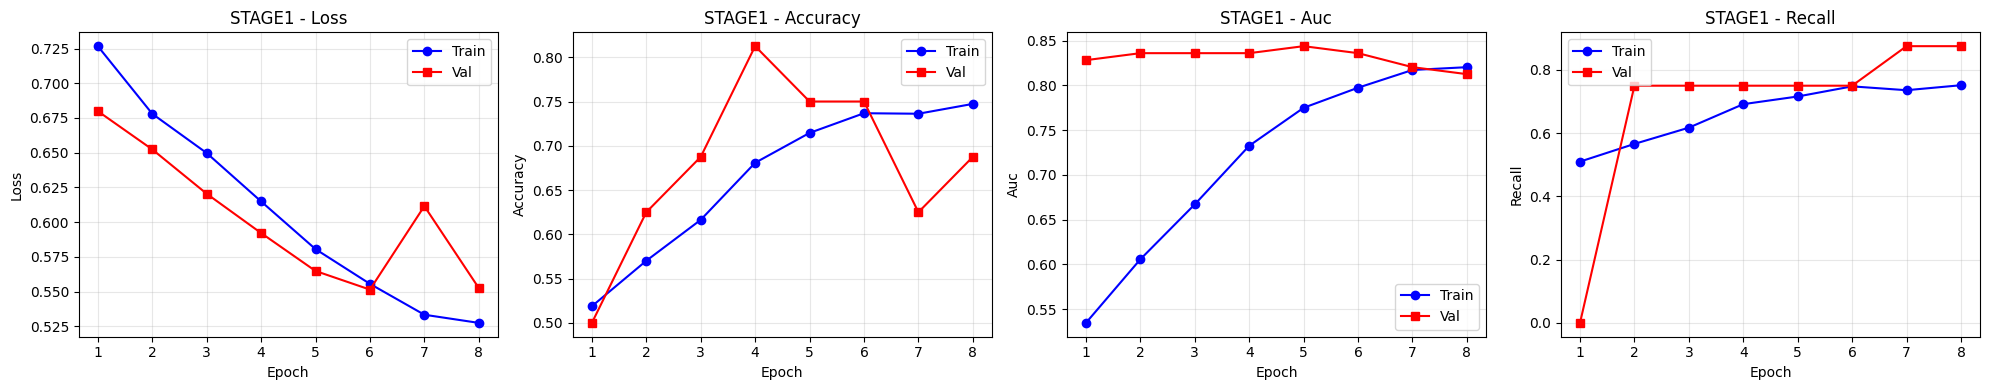


📈 Stage 1 Best Metrics:
  • val_loss: 0.5514 (epoch 6)
  • val_accuracy: 0.8125 (epoch 4)
  • val_auc: 0.8438 (epoch 5)
  • val_recall: 0.8750 (epoch 7)
  • val_precision: 0.8571 (epoch 4)


In [5]:
# Build model with frozen backbone
model = ModelBuilder.build(img_size=IMG_SIZE, trainable_backbone=False)
ModelBuilder.compile(model, learning_rate=1e-4)

# Initialize trainer
trainer = Trainer(model, output_dir=OUTPUT_DIR)

# Train Stage 1
history1 = trainer.train(
    train_gen, val_gen, 
    epochs=8,
    stage='stage1',
    class_weight=class_weights
)

# Visualize training history
trainer.plot_history(history1, 'stage1')
Utils.print_best_metrics(history1, 'Stage 1')

## 4. Training Stage 2: Fine-Tuning
Now we unfreeze the top layers of the backbone to fine-tune the feature representations.


──────────────────────────────────────────────────────────────────────
⚙️ COMPILING MODEL
──────────────────────────────────────────────────────────────────────
✓ Optimizer: Adam (lr=1e-05)
✓ Loss: Binary Crossentropy
✓ Metrics: ['accuracy', 'precision', 'recall', 'auc', 'auc_pr']

🚀 STAGE2
✓ Callbacks configured for stage2
⏱️ Starting: 2025-12-31 00:43:06
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7281 - auc: 0.8222 - auc_pr: 0.9283 - loss: 0.5924 - precision: 0.9070 - recall: 0.6832
Epoch 1: val_auc improved from -inf to 0.67969, saving model to /kaggle/working/run_20251231_002840/checkpoints/stage2_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 645ms/step - accuracy: 0.7288 - auc: 0.8228 - auc_pr: 0.9285 - loss: 0.5910 - precision: 0.9073 - recall: 0.6841 - val_accuracy: 0.5625 - val_auc: 0.6797 - val_auc_pr: 0.7100 - val_loss: 0.7384 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9081 - auc: 0.9654 - auc_pr: 0.9873 - loss: 0.2366 - precision: 0.9714 - recall: 0.9026
Epoch 2: val_auc improved from 0.67969 to 0.82812, saving model to /kaggle/working/run_20251231_002840/checkpoints/stage2_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.9081 - auc: 0.9654 - auc_pr: 0.9873 - loss: 0.2366 - precision: 0.9714 - recall: 0.9026 - val_accuracy: 0.6250 - val_auc: 0.8281 - val_auc_pr: 0.8111 - val_loss: 0.8061 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9153 - auc: 0.9700 - auc_pr: 0.9894 - loss: 0.2175 - precision: 0.9735 - recall: 0.9103
Epoch 3: val_auc improved from 0.82812 to 0.94531, saving model to /kaggle/working/run_20251231_002840/checkpoints/stage2_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.9153 - auc: 0.9700 - auc_pr: 0.9894 - loss: 0.2175 - precision: 0.9735 - recall: 0.9102 - val_accuracy: 0.8125 - val_auc: 0.9453 - val_auc_pr: 0.9522 - val_loss: 0.3448 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9238 - auc: 0.9731 - auc_pr: 0.9913 - loss: 0.2001 - precision: 0.9768 - recall: 0.9214
Epoch 4: val_auc did not improve from 0.94531
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9238 - auc: 0.9731 - auc_pr: 0.9913 - loss: 0.2001 - precision: 0.9768 - recall: 0.9213 - val_accuracy: 0.5625 - val_auc: 0.9375 - val_auc_pr: 0.9377 - val_loss: 0.9663 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 1.0000e-05
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9231 - auc: 0.9770 - auc_pr: 0.9913 - loss: 0.1883 - precision: 0.9820 - recall: 0.9119
Epoch 5: val_auc improved from 0.94531 to 0

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9231 - auc: 0.9770 - auc_pr: 0.9913 - loss: 0.1883 - precision: 0.9820 - recall: 0.9120 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_auc_pr: 0.9570 - val_loss: 0.3762 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.



💾 Model saved: /kaggle/working/run_20251231_002840/checkpoints/stage2_final.h5


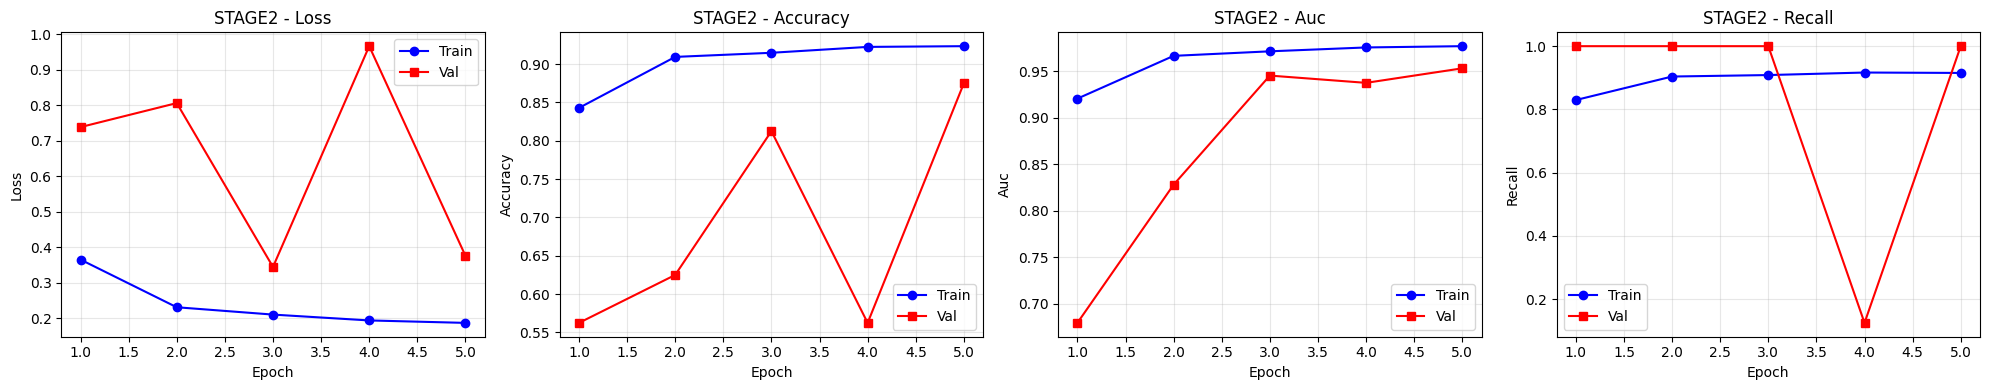


📈 Stage 2 Best Metrics:
  • val_loss: 0.3448 (epoch 3)
  • val_accuracy: 0.8750 (epoch 5)
  • val_auc: 0.9531 (epoch 5)
  • val_recall: 1.0000 (epoch 1)
  • val_precision: 1.0000 (epoch 4)


In [6]:
# Unfreeze layers
base_model = model.layers[1]
base_model.trainable = True
# Keep bottom layers frozen to prevent overfitting
for layer in base_model.layers[:140]:
    layer.trainable = False

# Recompile with lower learning rate
ModelBuilder.compile(model, learning_rate=1e-5)

# Train Stage 2
history2 = trainer.train(
    train_gen, val_gen, 
    epochs=5,
    stage='stage2',
    class_weight=class_weights
)

# Visualize fine-tuning history
trainer.plot_history(history2, 'stage2')
Utils.print_best_metrics(history2, 'Stage 2')

## 5. Save Model
We save the final fine-tuned model for future inference.

In [7]:
# Define path for final model
final_model_path = os.path.join(OUTPUT_DIR, "final_pneumonia_model.h5")

# Save model
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")
print(f"   (Checkpoints also saved in: {trainer.checkpoint_dir})")

✅ Final model saved to: /kaggle/working/final_pneumonia_model.h5
   (Checkpoints also saved in: /kaggle/working/run_20251231_002840/checkpoints)


## 6. Comprehensive Evaluation
Now that the model is trained, we evaluate its performance on the held-out test set.

In [8]:
import pandas as pd

# Ensure evaluation output directory exists
EVAL_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "evaluation_results")
os.makedirs(EVAL_OUTPUT_DIR, exist_ok=True)
print(f"Storing evaluation results in: {EVAL_OUTPUT_DIR}")

# Initialize Evaluator
evaluator = ModelEvaluator(model, test_gen)

# Calculate and save metrics
metrics = evaluator.calculate_metrics()
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(EVAL_OUTPUT_DIR, "metrics.csv"), index=False)
print(f"✓ Saved metrics to {EVAL_OUTPUT_DIR}/metrics.csv")

# Generate and save classification report
report = evaluator.generate_classification_report();
with open(os.path.join(EVAL_OUTPUT_DIR, "classification_report.txt"), 'w') as f:
    f.write(report)
print(f"✓ Saved report to {EVAL_OUTPUT_DIR}/classification_report.txt")

Storing evaluation results in: /kaggle/working/evaluation_results
📊 MODEL EVALUATOR INITIALIZED
✓ Model: PneumoniaNet
✓ Test samples: 624
✓ Classes: {'NORMAL': 0, 'PNEUMONIA': 1}

──────────────────────────────────────────────────────────────────────
📈 CALCULATING METRICS
──────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────
🔮 GENERATING PREDICTIONS
──────────────────────────────────────────────────────────────────────
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step
✓ Predictions shape: (624, 1)
✓ Positive predictions: 413/624

🎯 Performance Metrics:
──────────────────────────────────────────────────
  Accuracy...................... 0.8830 (88.30%)
  Precision..................... 0.8838 (88.38%)
  Recall (Sensitivity).......... 0.9359 (93.59%)
  Specificity................... 0.7949 (79.49%)
  F1-Score...................... 0.9091 (90.91%)
  AUC-ROC....................... 0.9396 (93.96%)
  AUC-PR.......

### Performance Visualizations


──────────────────────────────────────────────────────────────────────
🎨 PLOTTING CONFUSION MATRIX
──────────────────────────────────────────────────────────────────────


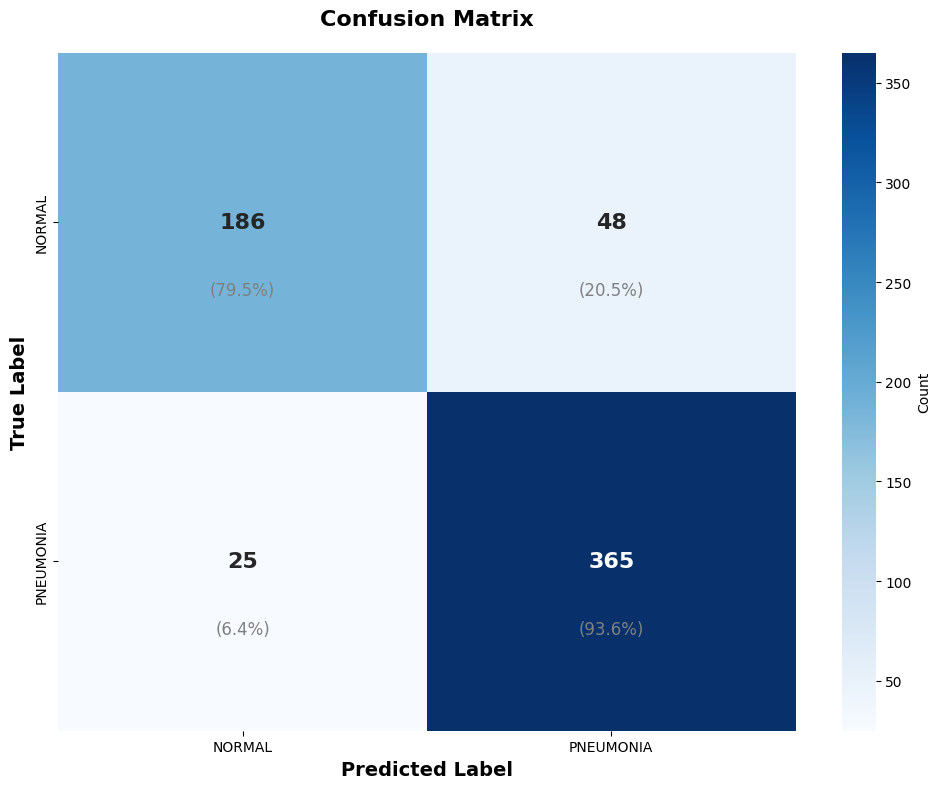


📋 Confusion Matrix Breakdown:
──────────────────────────────────────────────────
  True Negatives:   186 ( 29.8%)
  False Positives:   48 (  7.7%)
  False Negatives:   25 (  4.0%)
  True Positives:   365 ( 58.5%)
──────────────────────────────────────────────────


array([[186,  48],
       [ 25, 365]])

In [9]:
evaluator.plot_confusion_matrix(save_path=os.path.join(EVAL_OUTPUT_DIR, "confusion_matrix.png"))


──────────────────────────────────────────────────────────────────────
📉 PLOTTING ROC CURVE
──────────────────────────────────────────────────────────────────────


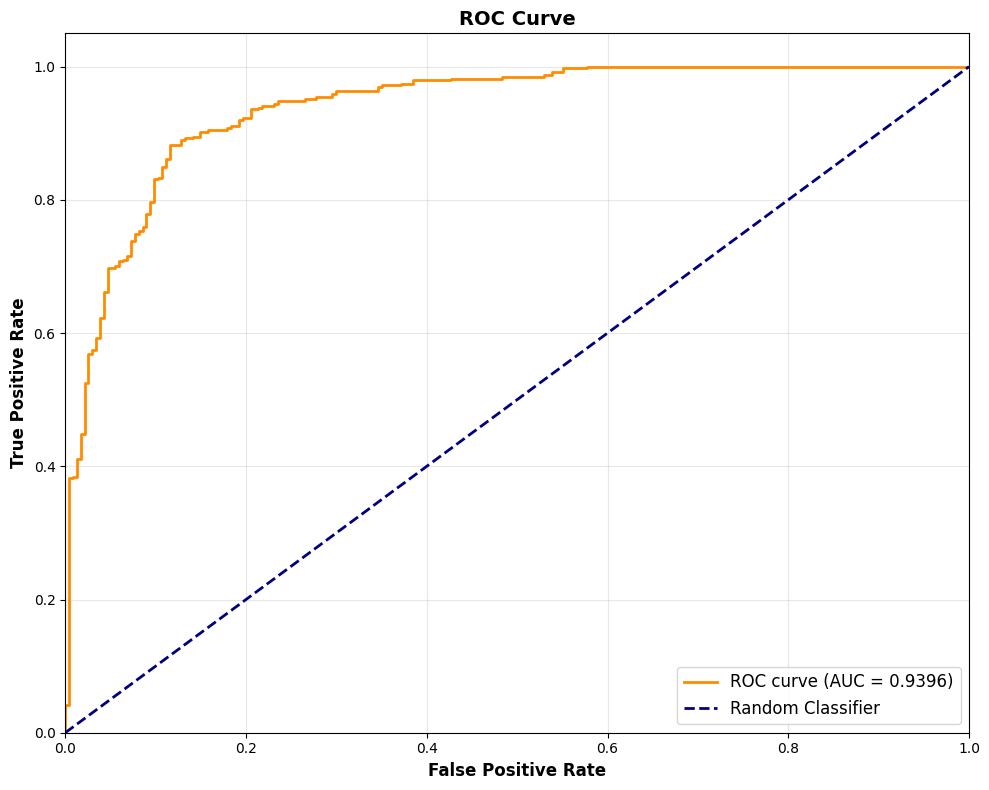

✓ AUC-ROC: 0.9396


(array([0.        , 0.        , 0.        , 0.0042735 , 0.0042735 ,
        0.0042735 , 0.0042735 , 0.0042735 , 0.0042735 , 0.00854701,
        0.00854701, 0.01282051, 0.01282051, 0.01709402, 0.01709402,
        0.02136752, 0.02136752, 0.02564103, 0.02564103, 0.02991453,
        0.02991453, 0.03418803, 0.03418803, 0.03846154, 0.03846154,
        0.04273504, 0.04273504, 0.04700855, 0.04700855, 0.05555556,
        0.05555556, 0.05982906, 0.05982906, 0.06410256, 0.06410256,
        0.06837607, 0.06837607, 0.07264957, 0.07264957, 0.07692308,
        0.07692308, 0.08119658, 0.08119658, 0.08547009, 0.08547009,
        0.08974359, 0.08974359, 0.09401709, 0.09401709, 0.0982906 ,
        0.0982906 , 0.0982906 , 0.1025641 , 0.1025641 , 0.10683761,
        0.10683761, 0.11111111, 0.11111111, 0.11538462, 0.11538462,
        0.12820513, 0.12820513, 0.13247863, 0.13247863, 0.14102564,
        0.14102564, 0.14957265, 0.14957265, 0.15811966, 0.15811966,
        0.17948718, 0.17948718, 0.18376068, 0.18

In [10]:
evaluator.plot_roc_curve(save_path=os.path.join(EVAL_OUTPUT_DIR, "roc_curve.png"))


──────────────────────────────────────────────────────────────────────
📉 PLOTTING PR CURVE
──────────────────────────────────────────────────────────────────────


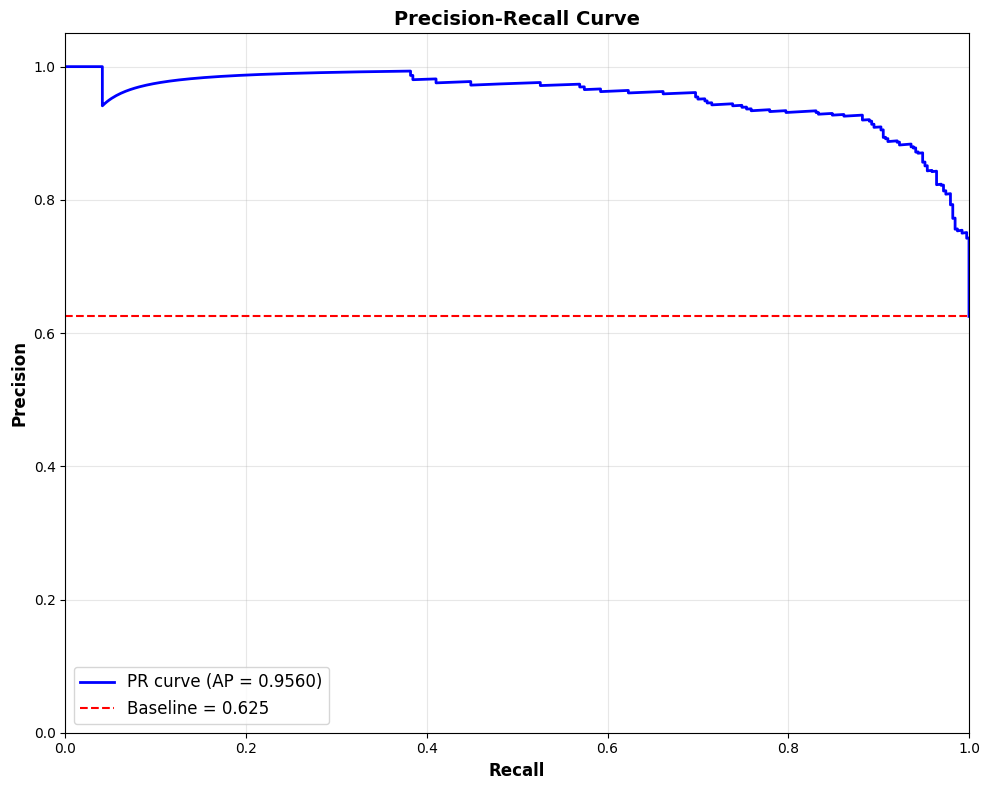

✓ Average Precision: 0.9560


(array([0.625     , 0.62600321, 0.62700965, 0.62801932, 0.62903226,
        0.63004847, 0.63106796, 0.63209076, 0.63311688, 0.63414634,
        0.63517915, 0.63621533, 0.6372549 , 0.63829787, 0.63934426,
        0.64039409, 0.64144737, 0.64250412, 0.64356436, 0.6446281 ,
        0.64569536, 0.64676617, 0.64784053, 0.64891847, 0.65      ,
        0.65108514, 0.65217391, 0.65326633, 0.65436242, 0.65546218,
        0.65656566, 0.65767285, 0.65878378, 0.65989848, 0.66101695,
        0.66213922, 0.66326531, 0.66439523, 0.66552901, 0.66666667,
        0.66780822, 0.66895369, 0.67010309, 0.67125645, 0.67241379,
        0.67357513, 0.67474048, 0.67590988, 0.67708333, 0.67826087,
        0.67944251, 0.68062827, 0.68181818, 0.68301226, 0.68421053,
        0.68541301, 0.68661972, 0.68783069, 0.68904594, 0.69026549,
        0.69148936, 0.69271758, 0.69395018, 0.69518717, 0.69642857,
        0.69767442, 0.69892473, 0.70017953, 0.70143885, 0.7027027 ,
        0.70397112, 0.70524412, 0.70652174, 0.70

In [11]:
evaluator.plot_precision_recall_curve(save_path=os.path.join(EVAL_OUTPUT_DIR, "pr_curve.png"))

## 7. Explainability (Grad-CAM)
We use Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize which regions of the X-ray the model focuses on when making predictions. This is crucial for verifying medical relevance.

🔥 GRAD-CAM VISUALIZER (v5.0 - Hybrid)
  ✓ Built flat model with 3 layers
✓ Target layer: conv5_block3_out
✓ Gradient model built
⚠️  Gradients not working - using activation-based CAM
\n──────────────────────────────────────────────────────────────────────\n🖼️  BATCH VISUALIZATION (8 samples)\n──────────────────────────────────────────────────────────────────────
Using method: Activation-based CAM


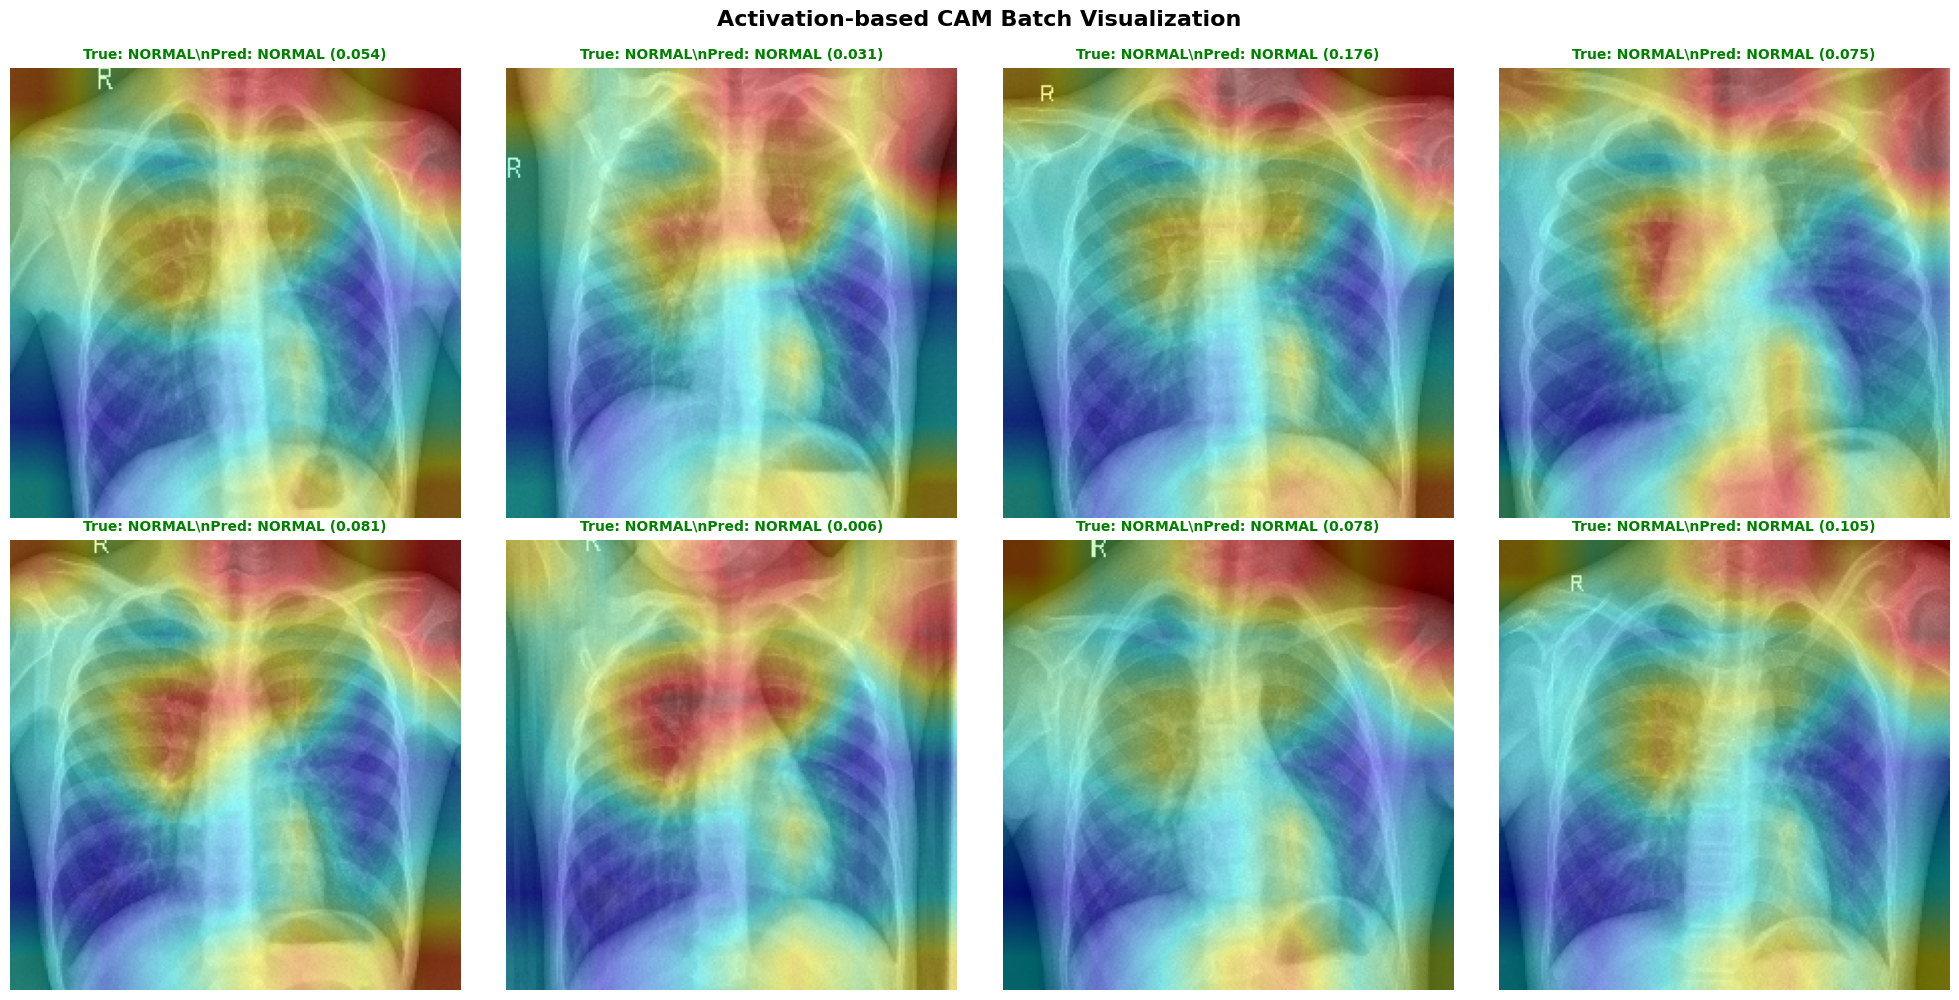

\n✓ Successfully generated 8/8 heatmaps using Activation-based CAM


In [12]:
gradcam = GradCAMVisualizer(model)

# Visualize and save a batch of random samples
gradcam.visualize_batch(
    test_gen, 
    num_samples=8, 
    save_path=os.path.join(EVAL_OUTPUT_DIR, "gradcam_batch.png")
)